#Analyze Spotify Genre
##In this notebook, I fed the data into a multi-class classification algorithm to try to predict the genre of a song based on the audible attributes. For the purpose of limiting the genres to classify, I went with songs within just the top 7 most popular genres according to the genre analysis done in previous secitons. With some optimizations and a little leeway, the algorithm was able to predict a songs genre with about 68% accuracy in 1 prediction and with about 84% accuracy with 2 predictions. I was fairly satisfied with this result given the difficulty of 7-way classification.

## Data Preprocessing:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both.csv


In [2]:
track_table = pd.read_csv("cleaned_tracks_both.csv")
track_table.dropna(inplace=True)

A quick reminder about the number of tracks per genre:

In [3]:
track_table.groupby("master_popular_genre").track_id.count()

master_popular_genre
country    10005
hiphop     10728
house       6529
indie       7673
pop        17277
r&b         5505
rock        8967
Name: track_id, dtype: int64

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics = pd.concat([track_table.select_dtypes(include=[np.number]),track_table['master_popular_genre']],axis=1, sort=False)

One more look at the data:

In [5]:
track_table_dummies = pd.get_dummies(data_numerics,columns=['key','time_signature',],drop_first=True)
track_table_dummies = track_table_dummies.drop('loudness', axis=1)
track_table_dummies.head()

,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,master_popular_genre,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,pop,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,rock,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,rock,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,pop,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,42,2011,294613,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,rock,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
#move genre to front
genre = track_table_dummies['master_popular_genre']
track_table_dummies.drop('master_popular_genre', axis=1,inplace = True)
track_table_dummies.insert(0, 'master_popular_genre', genre)

In [7]:
track_table_dummies.head()

,master_popular_genre,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,pop,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,rock,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,rock,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,pop,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,rock,42,2011,294613,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [79]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Here are the 7 possible genre classifications:

In [80]:
print("Genres:",y_train.unique())

Genres: ['house' 'pop' 'hiphop' 'r&b' 'country' 'rock' 'indie']


## Training the model:
Piggybacking off the success of the Gradient Boost from the previous exploration, I chose to try a Gradient Boost classifier first for the multi-class classification. I chose not to vary a ton of parameters here, as it took 5-10 minutes per iteration. With cross-validation and a grid search of 3-4 different variables, this optimization takes hours.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
genre_order = ['country', 'hiphop', 'house', 'indie', 'pop', 'r&b', 'rock']

In [9]:
def print_accuracy(genre_index, conf_matrix):
  print("Accuracy predicting", genre_order[genre_index], ":", conf_matrix[genre_index,genre_index]/(sum(conf_matrix[genre_index,:])))

In [10]:
def print_grid_results(grid, x_test, y_test):
  conf_matrix = confusion_matrix(y_test, grid.predict(X_test), labels=genre_order)
  print("The best score is {}".format(grid.best_score_))
  print("The best hyper parameter setting is {}".format(grid.best_params_))
  print("Model Accuracy:", accuracy_score(y_test,grid.predict(X_test)))
  print()
  for i in range(0,len(genre_order)):
    print_accuracy(i,conf_matrix)
  fig, ax = plt.subplots(figsize=(12,10)) 
  sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
  ax.set(xlabel='Predicted Genre', ylabel='True Genre')
  ax.set_title("Proportional Genre Confusion Matrix")


In [82]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [500]
}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=500 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=500, total=  45.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.5s remaining:    0.0s


[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=  44.2s
[CV] n_estimators=500 ................................................
[CV] ................................. n_estimators=500, total=  44.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min finished


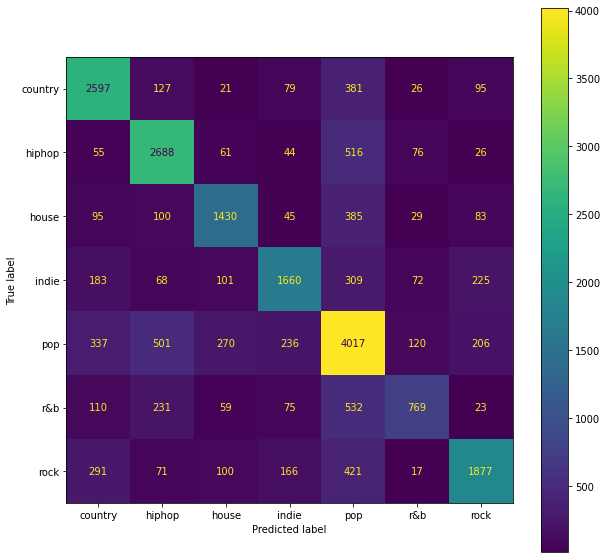

In [83]:
conf_matrix = confusion_matrix(y_test, grid_rf.predict(X_test), labels=genre_order)
fig, ax = plt.subplots(figsize=(10, 10))
print(plot_confusion_matrix(X=X_test,y_true=y_test, labels=genre_order,estimator=grid_rf, ax=ax,values_format = 'd'))

The best score is 0.638367785767261
The best hyper parameter setting is {'n_estimators': 500}
Model Accuracy: 0.6833590838862128

Accuracy predicting country : 0.780817799158148
Accuracy predicting hiphop : 0.775533756491633
Accuracy predicting house : 0.6598984771573604
Accuracy predicting indie : 0.6340718105423988
Accuracy predicting pop : 0.7063478107965535
Accuracy predicting r&b : 0.42745969983324067
Accuracy predicting rock : 0.6377845735643901


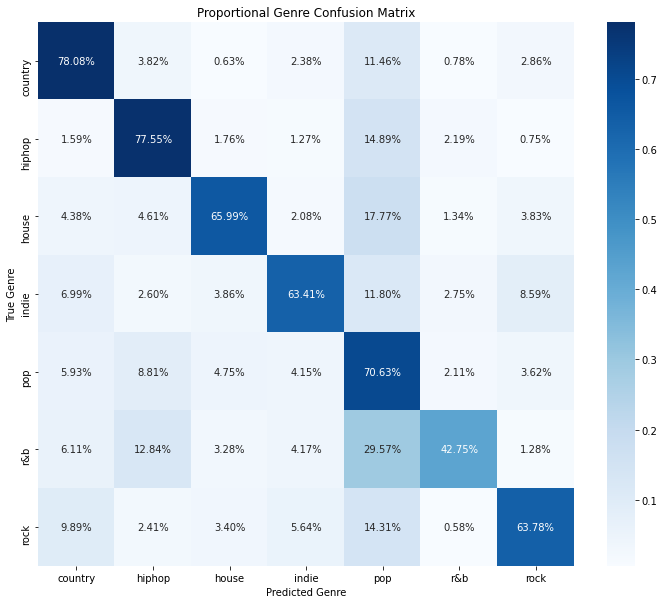

In [84]:
print_grid_results(grid_rf,X_test,y_test)

In [85]:
for count,genre_preds in enumerate(conf_matrix):
  print("True Genre:", genre_order[count])
  genre_preds[list(genre_preds).index(max(genre_preds))] = 0
  incorrect_guess = genre_order[list(genre_preds).index(max(genre_preds))]
  print("Most Common Incorrect Prediction:", incorrect_guess)
  print("Percent of All Incorrect Predictions as", incorrect_guess, (max(genre_preds) / sum(genre_preds)))
  print()

True Genre: country
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.522633744855967

True Genre: hiphop
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.6632390745501285

True Genre: house
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.5223880597014925

True Genre: indie
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.32254697286012524

True Genre: pop
Most Common Incorrect Prediction: hiphop
Percent of All Incorrect Predictions as hiphop 0.3

True Genre: r&b
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.516504854368932

True Genre: rock
Most Common Incorrect Prediction: pop
Percent of All Incorrect Predictions as pop 0.3949343339587242



Rebalance dataset, try again:

In [11]:
from sklearn.utils import resample

In [12]:
df_nonpop = track_table_dummies[track_table_dummies['master_popular_genre']!='pop']
df_pop = track_table_dummies[track_table_dummies['master_popular_genre']=='pop']
samp = 10000
# Downsample majority class
df_pop_downsampled = resample(df_pop, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000) # reproducible results
 
# Combine minority class with downsampled majority class
df_pop_downsampled = pd.concat([df_pop_downsampled, df_nonpop])
 
# Display new class counts
df_pop_downsampled.master_popular_genre.value_counts()

hiphop     10728
country    10005
pop        10000
rock        8967
indie       7673
house       6529
r&b         5505
Name: master_popular_genre, dtype: int64

In [ ]:
X = df_pop_downsampled.iloc[:,1:]
y = df_pop_downsampled.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650]
}
grid_rf_under = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=650 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=650, total=  52.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.5s remaining:    0.0s


[CV] n_estimators=650 ................................................
[CV] ................................. n_estimators=650, total=  53.9s
[CV] n_estimators=650 ................................................
[CV] ................................. n_estimators=650, total=  51.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min finished


Undersampling pop tracks:
The best score is 0.6424803065888914
The best hyper parameter setting is {'n_estimators': 650}
Model Accuracy: 0.6823259372609028

Accuracy predicting country : 0.8189024390243902
Accuracy predicting hiphop : 0.8357695614789338
Accuracy predicting house : 0.7163836622303809
Accuracy predicting indie : 0.6448963629253031
Accuracy predicting pop : 0.47862232779097386
Accuracy predicting r&b : 0.5195968645016797
Accuracy predicting rock : 0.6873727087576375


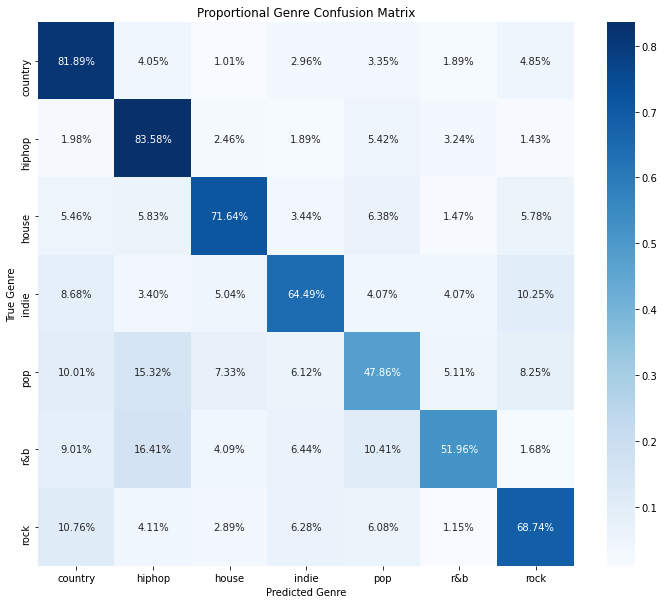

In [ ]:
print("Undersampling pop tracks:")
print_grid_results(grid_rf_under,X_test,y_test)

Only Oversampling

In [13]:
def oversample(frame, genre, numTracks):
  df = frame[frame['master_popular_genre']==genre]
  df_upsampled = resample(df, replace=True, n_samples=numTracks)
  return df_upsampled

In [14]:
samp = 10000

df_rb = oversample(track_table_dummies,"r&b", samp)
df_house = oversample(track_table_dummies,"house", samp)
df_indie = oversample(track_table_dummies,"indie", samp)
df_rock = oversample(track_table_dummies,"rock", samp)

df_rest = track_table_dummies[track_table_dummies['master_popular_genre']!='r&b']
df_rest = df_rest[df_rest['master_popular_genre']!='house']
df_rest = df_rest[df_rest['master_popular_genre']!='indie']
df_rest = df_rest[df_rest['master_popular_genre']!='rock']

# Combine minority class with downsampled majority class
df_upsampled = pd.concat([df_rest, df_rb, df_house, df_indie, df_rock])
 
# Display new class counts
df_upsampled.master_popular_genre.value_counts()

pop        17277
hiphop     10728
country    10005
house      10000
rock       10000
r&b        10000
indie      10000
Name: master_popular_genre, dtype: int64

In [ ]:
X = df_upsampled.iloc[:,1:]
y = df_upsampled.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650]
}
grid_rf_up = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)

In [ ]:
print("Oversampling less frequent genres:")
print_grid_results(grid_rf_up,X_test,y_test)

Oversampling and Undersampling

In [15]:
df_nonpop = df_upsampled[df_upsampled['master_popular_genre']!='pop']
df_pop = df_upsampled[df_upsampled['master_popular_genre']=='pop']
samp = 10000
# Downsample majority class
df_downsampled = resample(df_pop, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000) # reproducible results
 
# Combine minority class with downsampled majority class
df_both = pd.concat([df_downsampled, df_nonpop])
 
# Display new class counts
df_both.master_popular_genre.value_counts()

hiphop     10728
country    10005
house      10000
pop        10000
rock       10000
r&b        10000
indie      10000
Name: master_popular_genre, dtype: int64

In [ ]:
X = df_both.iloc[:,1:]
y = df_both.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650]
}
grid_rf_balanced = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=2).fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] n_estimators=650 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................. n_estimators=650, total= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] n_estimators=650 ................................................
[CV] ................................. n_estimators=650, total= 1.1min
[CV] n_estimators=650 ................................................
[CV] ................................. n_estimators=650, total= 1.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min finished


Undersampling pop tracks and oversampling uncommon genres:
The best score is 0.7384735498301366
The best hyper parameter setting is {'n_estimators': 650}
Model Accuracy: 0.7965041555993488

Accuracy predicting country : 0.8242956679794002
Accuracy predicting hiphop : 0.8262977752424415
Accuracy predicting house : 0.9073677774380923
Accuracy predicting indie : 0.8493150684931506
Accuracy predicting pop : 0.44961715160796323
Accuracy predicting r&b : 0.8931207558311189
Accuracy predicting rock : 0.8184550646227833


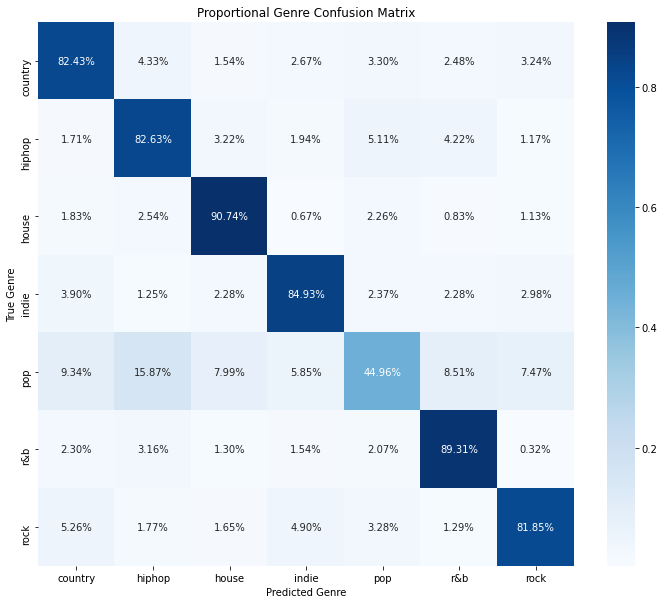

In [ ]:
print("Undersampling pop tracks and oversampling uncommon genres:")
print_grid_results(grid_rf_balanced,X_test,y_test)

In [18]:
X = df_both.iloc[:,1:]
y = df_both.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

rf_param_grid = {
          #'bootstrap': [True, False],
          'bootstrap': [False],
          # 'max_depth': [10, 50, 100, None],
          'max_depth': [100],
          #'max_features': ['auto', 'sqrt'],
          'max_features': ['auto'],
          #'n_estimators': [600, 1000, 1400, 1800, 2000]
          'n_estimators': [1400]
}
grid_rf_opt = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 4.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.4min remaining:    0.0s


[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 4.1min
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 4.3min
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 4.1min
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 4.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 22.6min finished


Undersampling pop tracks and oversampling uncommon genres:
The best score is 0.7667911704777775
The best hyper parameter setting is {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1400}
Model Accuracy: 0.8028874989289693

Accuracy predicting country : 0.8282338685246895
Accuracy predicting hiphop : 0.8311466058185967
Accuracy predicting house : 0.8978905533476002
Accuracy predicting indie : 0.84779299847793
Accuracy predicting pop : 0.5215926493108729
Accuracy predicting r&b : 0.8777679362267493
Accuracy predicting rock : 0.810039074241058


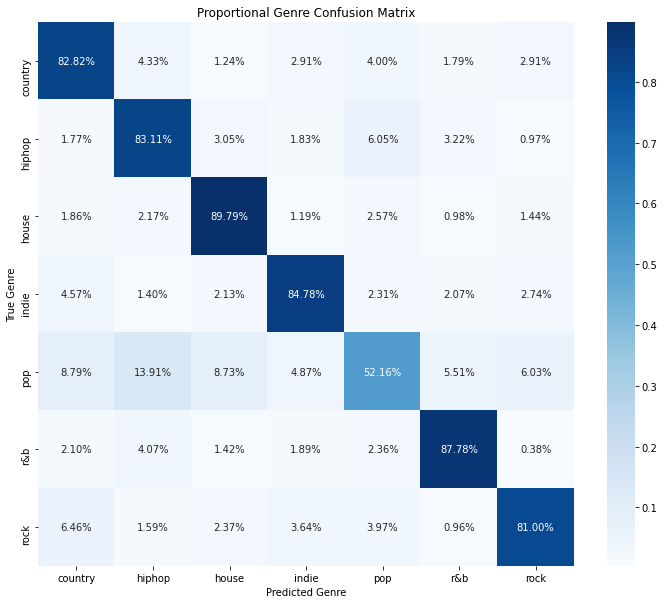

In [19]:
print("Undersampling pop tracks and oversampling uncommon genres:")
print_grid_results(grid_rf_opt,X_test,y_test)

##Let's see some predictions

In [23]:
preds = []
for prediction in grid_rf_opt.predict_proba(X_test):
  pred_ind = []
  prediction = list(prediction)
  pred_ind.append(max(prediction))
  pred_ind.append(prediction.index(max(prediction)))
  preds.append(pred_ind)

for pred in preds:
  pred[1] = genre_order[pred[1]]

In [31]:
in_list = []
for i in range(0,len(preds)):
  in_list.append(int(list(y_test)[i] == preds[i][1]))

In [49]:
prediction_conf = []
predicted_genre = []

for i in range(0,len(y_test)):
  prediction_conf.append(preds[i][0])
  predicted_genre.append(preds[i][1])


prediction_frame = pd.DataFrame({"Prediction Confidence":prediction_conf,
                                 "Predicted Correctly":in_list,
                                 "True Genre": y_test,
                                 "Predicted Genre": predicted_genre,
                                 "Track Name": track_table.track_name[y_test.index],
                                 "Artist Name": track_table.art_name[y_test.index]})

Text(0.5, 1.0, 'Prediction Confidence')

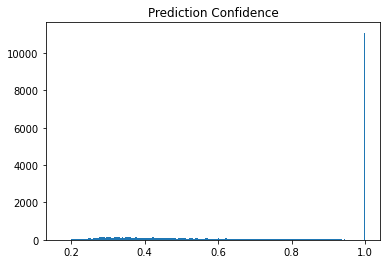

In [62]:
import matplotlib.pyplot as plt
plt.hist(prediction_frame["Prediction Confidence"],bins=200)  #Chose 47 because it results in bins of size 2 (0-2,2-4, etc)
plt.title("Prediction Confidence")

In [58]:
prediction_frame.drop_duplicates().sort_values(by="Prediction Confidence", ascending=False).head(20)

,Prediction Confidence,Predicted Correctly,True Genre,Predicted Genre,Track Name,Artist Name
35222,1.0,1,indie,indie,Born Again,Saint Motel
32861,1.0,1,r&b,r&b,Waiting Game,BANKS
1226,1.0,1,rock,rock,Dark Turn Of Mind,Gillian Welch
43092,1.0,1,pop,pop,Brother (feat. Gavin DeGraw),NEEDTOBREATHE
50600,1.0,1,indie,indie,Accelerate,Jungle
26535,1.0,1,house,house,"Wake Up, You're Dreaming",Notaker
30855,1.0,1,indie,indie,Sarah,Alex G
55053,1.0,1,r&b,r&b,This Bag,Mac Ayres
45280,1.0,1,pop,pop,1950,King Princess
41306,1.0,1,pop,pop,Bad Girls,M.I.A.


In [57]:
prediction_frame[prediction_frame['Predicted Correctly'] == 0].drop_duplicates().sort_values(by="Prediction Confidence", ascending=False).head(20)

,Prediction Confidence,Predicted Correctly,True Genre,Predicted Genre,Track Name,Artist Name
23018,0.947143,0,pop,house,Stone,Robin Schulz
8203,0.943571,0,pop,country,Take You Home,Cassadee Pope
65718,0.936429,0,pop,country,One Little Lie,Simple Creatures
23704,0.907143,0,pop,house,Wizard - Tchami Remix,Martin Garrix
45492,0.907143,0,pop,hiphop,Be Careful,Cardi B
22025,0.899286,0,pop,house,Phat Brahms,Steve Aoki
21816,0.898571,0,pop,house,Spectrum - Armin Van Buuren Remix,Zedd
23773,0.897857,0,pop,house,Walk This Way - Alle Farben Remix,MØ
20339,0.896429,0,pop,house,The Legend of Zelda - Club Mix,Zedd
30185,0.895000,0,indie,hiphop,Wildfire - OVO Remix,SBTRKT


#Predict 2 Genres

In [65]:
# Add prediction of 2nd highest probability genre
two_preds = []
for prediction in grid_rf_opt.predict_proba(X_test):
  prediction = list(prediction)
  two_maxes = []
  two_maxes.append(prediction.index(max(prediction)))
  prediction[prediction.index(max(prediction))] = 0
  two_maxes.append(prediction.index(max(prediction)))
  two_preds.append(two_maxes)

In [66]:
# Convert probability to genre name
for pred in two_preds:
  pred[0] = genre_order[pred[0]]
  pred[1] = genre_order[pred[1]]

In [67]:
# Create list to evaluate accuracy
in_list = []
for i in range(0,len(two_preds)):
  in_list.append(int(list(y_test)[i] in two_preds[i]))

In [68]:
print("Accuracy:" , sum(in_list) / len(in_list))

Accuracy: 0.891868734470054


In [69]:
pred_correctly = []
true_genre = []
predicted_genre = []

for i in range(0,len(y_test)):
  pred_correctly.append(in_list[i])
  true_genre.append(list(y_test)[i])
  predicted_genre.append(two_preds[i])

prediction_frame = pd.DataFrame({"Predicted Correctly":pred_correctly,
                                 "True Genre": true_genre,
                                 "Predicted Genres": predicted_genre,
                                 "Track Name": track_table.track_name[y_test.index],
                                 "Artist Name": track_table.art_name[y_test.index]})

In [76]:
display(prediction_frame[prediction_frame["Predicted Correctly"] == 0])

,Predicted Correctly,True Genre,Predicted Genres,Track Name,Artist Name
16204,0,hiphop,"[pop, country]",Salute,Future
5315,0,country,"[indie, pop]",The Only Thing Worth Fighting For - From The H...,Lera Lynn
48002,0,r&b,"[country, pop]",Trust in Me Now,Anthony Evans
66551,0,indie,"[country, rock]",Valentine,COIN
52629,0,r&b,"[country, pop]",Trainwreck,BANKS
...,...,...,...,...,...
25208,0,indie,"[house, rock]",Kiss the Sky (feat. Wyclef Jean),The Knocks
32520,0,pop,"[rock, indie]",Paracosm,Washed Out
15727,0,hiphop,"[pop, r&b]",Boogieman,Childish Gambino
53715,0,r&b,"[pop, country]",Burn Slow,Ro James


Filtering out pop

In [77]:
df_nonpop = df_both[track_table_dummies['master_popular_genre']!='pop']
df_nonpop.master_popular_genre.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


hiphop     10728
country    10005
house      10000
rock       10000
r&b        10000
indie      10000
Name: master_popular_genre, dtype: int64

NONPOP RF

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 2.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 2.5min
[CV] bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400 
[CV]  bootstrap=False, max_depth=100, max_features=auto, n_estimators=1400, total= 2.5min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.2min finished


The best score is 0.811751903309203
The best hyper parameter setting is {'bootstrap': False, 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1400}
Model Accuracy: 0.8618401357149985

Accuracy predicting country : 0.8350856112946831
Accuracy predicting hiphop : 0.8672742808316719
Accuracy predicting house : 0.9096130592503023
Accuracy predicting indie : 0.8489296636085627
Accuracy predicting pop : nan
Accuracy predicting r&b : 0.8896361968816876
Accuracy predicting rock : 0.8210557709513868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


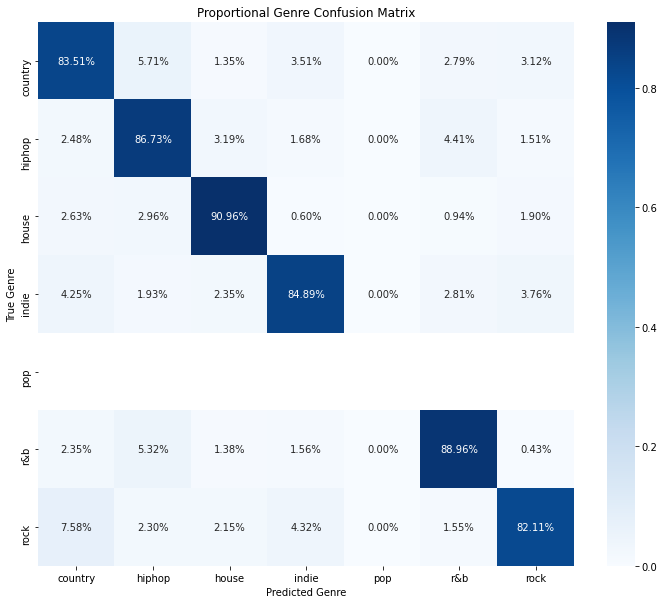

In [78]:
from sklearn.ensemble import RandomForestClassifier
X = df_nonpop.iloc[:,1:]
y = df_nonpop.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
gb_param_grid = {
          #'bootstrap': [True, False],
          'bootstrap': [False],
          # 'max_depth': [10, 50, 100, None],
          'max_depth': [100],
          #'max_features': ['auto', 'sqrt'],
          'max_features': ['auto'],
          #'n_estimators': [600, 1000, 1400, 1800, 2000]
          'n_estimators': [1400]
}
grid_rf_nonpop = GridSearchCV(RandomForestClassifier(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)
print_grid_results(grid_rf_nonpop,X_test,y_test)